## Imports

In [1]:
# import torch
# print(torch.cuda.is_bf16_supported()) # Should be True

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2

In [3]:
import spoofdet.config as config
from spoofdet.efficient_net.model_utils import get_transform_pipeline, evaluate_model, train_model, check_image, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result, save_results, analyze_spoof_types, analyze_dataset_spoof_distribution, display_params, verify_subject_split, get_data_for_training
from spoofdet.dataset import CelebASpoofDataset

## randomizer

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## params

In [5]:



PARAM_MULTIPLIER = 1

MODEL_NAME = "efficientnet_v2_s"
BATCH_SIZE= 32 * PARAM_MULTIPLIER


EPOCHS = 50
EARLY_STOPPING_LIMIT = 10
TARGET_SIZE = 320
#TARGET_SIZE = config.TARGET_SIZE
LEARNING_RATE = 1e-3 * PARAM_MULTIPLIER

BACKBONE_LR = 1e-5
HEAD_LR = 1e-3
WEIGHT_DECAY = 1e-4 * PARAM_MULTIPLIER


NUM_UNFROZEN_LAYERS = 2



WORKERS = 2

SPOOF_PERCENT = 0.5
TRAIN_IMG_COUNT = 10000
VAL_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.2)  
# VAL_IMG_COUNT = 1000
TEST_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.1)  
    # 0.001


## Model


In [6]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

for param in model.features.parameters():
    param.requires_grad = False

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)

target_stages = [5,6, 7]

for i in target_stages:

    for param in model.features[i].parameters():
        param.requires_grad = True


for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.track_running_stats = True
        for param in module.parameters():
            param.requires_grad = True

## preparation


In [7]:
import multiprocessing
from torch.utils.data import Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"
num_cpus = multiprocessing.cpu_count()
weights = torch.tensor([1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = torch.optim.AdamW([
    {'params': model.features.parameters(), 'lr': BACKBONE_LR},
    {'params': model.classifier.parameters(), 'lr': HEAD_LR},
    
], weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
    # mode='min',      
    # factor=0.5,       
    # patience=3,      
    # min_lr=[1e-7, 1e-6])
device

device(type='cuda')

In [8]:
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [9]:
train_dict, val_dict = get_data_for_training(config.TRAIN_JSON, train_count=TRAIN_IMG_COUNT, val_count=VAL_IMG_COUNT)



train_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=train_dict,
    bbox_json_path=config.BBOX_LOOKUP,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

val_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=val_dict,
    bbox_json_path=config.BBOX_LOOKUP,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=config.BBOX_LOOKUP,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE,
)



Total training images: 494405
Subjects: 8192 total, 6553 train, 1639 val
Images: 395427 train, 98978 val
Subject-split - Train: 395427, Val: 98978
Training set: 10000 images
  Live: 5000 (50.0%)
  Spoof: 5000 (50.0%)
Validation set: 2000 images
  Live: 1000 (50.0%)
  Spoof: 1000 (50.0%)
Loading BBox Cache into RAM...
Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


In [10]:
# 

In [11]:
len(train_ds)

10000

In [12]:

# # np.random.seed(seed)

# # small_train_ds = create_subset(train_ds, total_size=TRAIN_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
# # small_val_ds = create_subset(val_ds, total_size=VAL_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=TEST_IMG_COUNT)
# # print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning specific indices for class balance...
 Found in this split: 19923 Live | 47247 Spoof


In [13]:
# len(train_ds)

In [14]:
len(val_ds)

2000

In [15]:
# Diagnostic: Check label values in validation set
all_labels = []
for _, label in val_ds:
    all_labels.append(label.item())

unique_labels = set(all_labels)
print(f"Unique labels in validation set: {unique_labels}")

if any(l > 1 for l in unique_labels):
    print("WARNING: Found labels > 1. Model expects binary (0/1). This will cause errors/NaN.")
else:
    print("Labels look correct (binary).")

Unique labels in validation set: {0, 1}
Labels look correct (binary).


In [16]:

# # 1 = spoof  0 = live 
# check_image(train_ds, 210)

In [17]:
# check distribution of live and spoof in small_test_ds
# checkDatasetDistribution(small_test_ds)

In [18]:
# checkDatasetDistribution(small_train_ds)

In [19]:
# checkDatasetDistribution(small_val_ds)

## Data Loader

In [20]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True,
                                drop_last=True
          

)
small_val_loader = DataLoader(val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=WORKERS,
                              pin_memory=True,
                              persistent_workers=True
                

)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [21]:
sample_img, sample_label = train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 600, 600]), tensor(0))

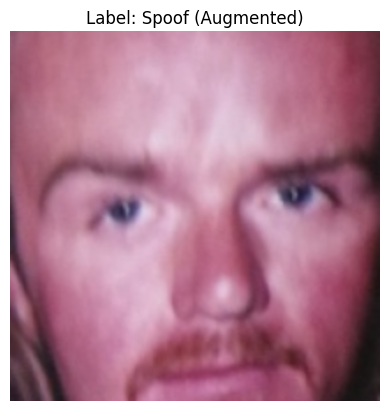

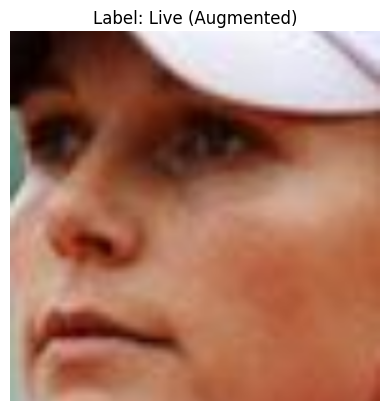

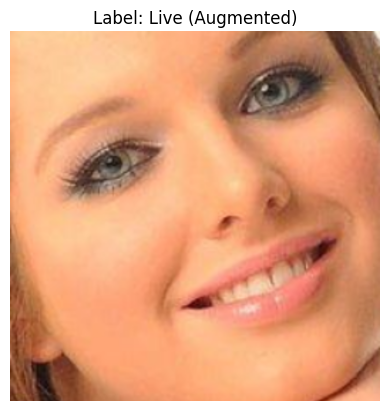

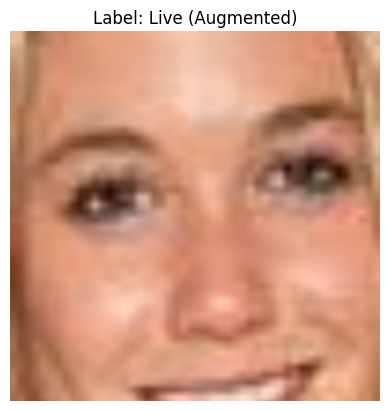

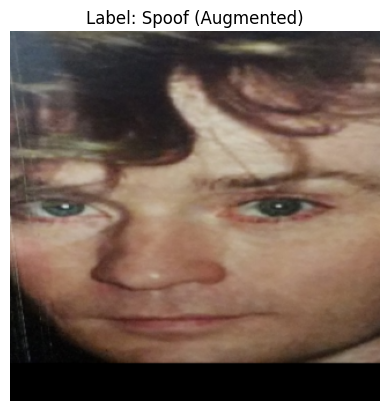

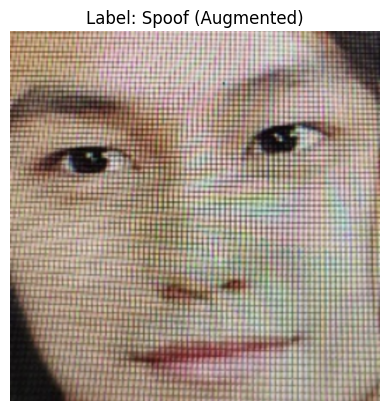

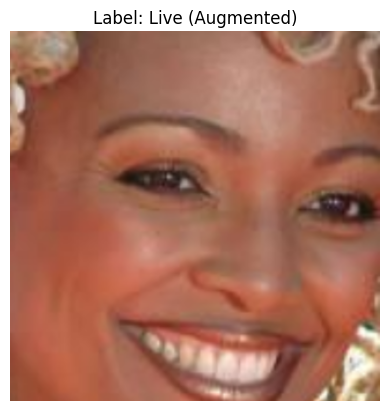

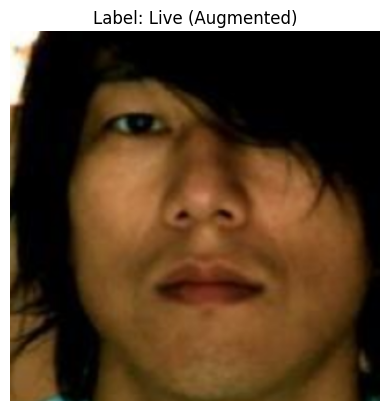

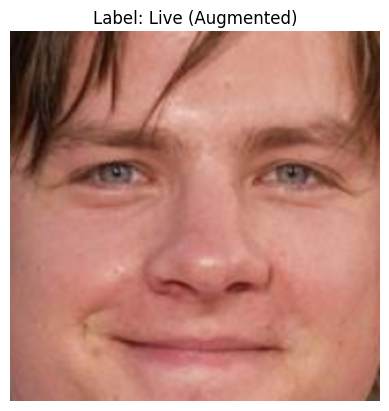

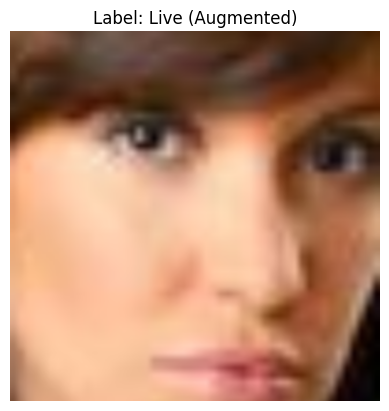

In [22]:
for i in range(10):
    checkAugmentedImage(val_ds, i, gpu_transforms=gpu_transforms_val)

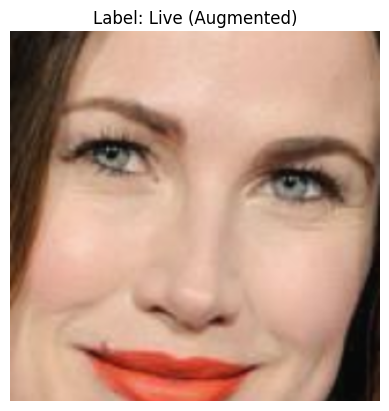

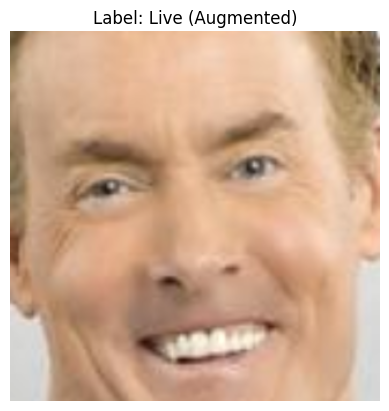

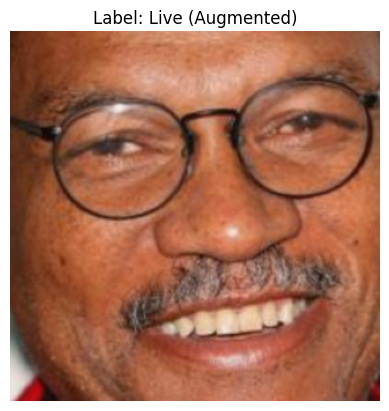

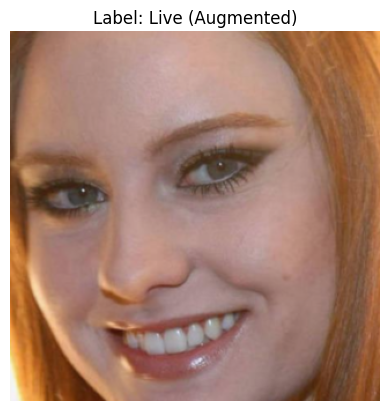

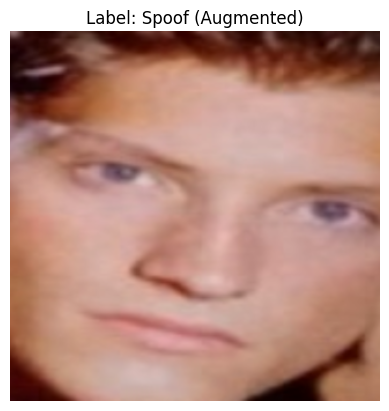

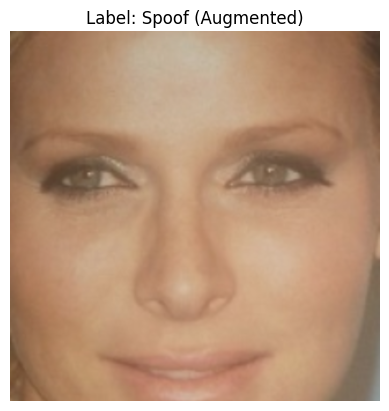

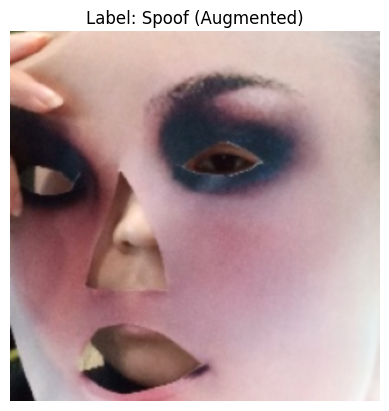

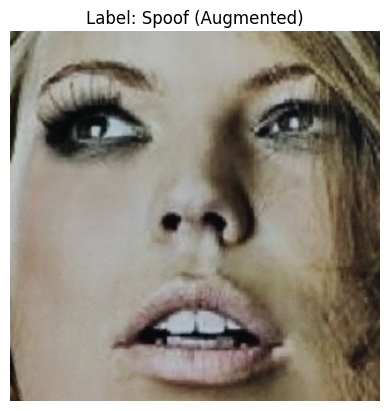

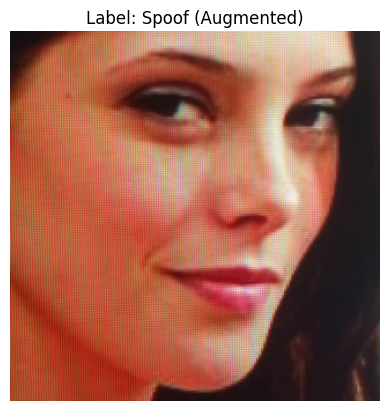

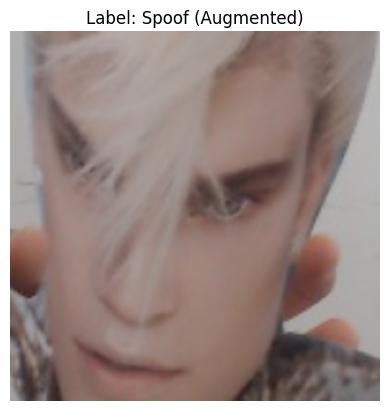

In [23]:
for i in range(10):
    checkAugmentedImage(train_ds, i, gpu_transforms=gpu_transforms_train)

In [24]:
# Debug: Add this before training
img, label = next(iter(small_train_loader))
print(f"Dataset output dtype: {img.dtype}, range: [{img.min()}, {img.max()}]")

img, label = img.to(device), label.to(device)
img_train, label_train = gpu_transforms_train(img, label)
img_val = gpu_transforms_val(img)
print(f"After train transforms: [{img_train.min():.2f}, {img_train.max():.2f}]")
print(f"After val transforms: [{img_val.min():.2f}, {img_val.max():.2f}]")

Dataset output dtype: torch.uint8, range: [0, 255]
After train transforms: [-2.12, 2.64]
After val transforms: [-2.12, 2.64]


In [25]:
# def reset_bn_stats(model, loader, device):
#     """
#     Resets running stats of BatchNorm layers and re-computes them
#     using the current training data.
#     """
#     print("Resetting BatchNorm statistics... (Warmup)")
#     model.train()
    
#     # Reset running stats to defaults
#     for module in model.modules():
#         if isinstance(module, torch.nn.BatchNorm2d):
#             module.reset_running_stats()
#             module.momentum = 0.1 

#     # Pass data through to update stats
#     # use val_transforms to avoid MixUp/CutMix tuple issues and get stable stats
#     with torch.no_grad():
#         for i, (imgs, _) in enumerate(loader):
#             if i >= 100: break # Use 100 batches to estimate stats
#             imgs = imgs.to(device)
#             # Use VALIDATION transforms (Normalize only) to ensure Type safety (Float)
#             # and avoid MixUp/CutMix tuple returns.
#             imgs = gpu_transforms_val(imgs) 
#             model(imgs) # Forward pass updates running stats
    
#     print("BatchNorm stats re-calibrated.")
#     return

# # Call this BEFORE starting the training loop
# # We use small_train_loader to get TRAINING data statistics
# reset_bn_stats(model, small_train_loader, device)

In [26]:
params = display_params(model_name=MODEL_NAME,lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, batch_size=BATCH_SIZE, epochs=EPOCHS, early_stopping_limit=EARLY_STOPPING_LIMIT,target_size=TARGET_SIZE, train_size=TRAIN_IMG_COUNT, val_size=VAL_IMG_COUNT,  num_unfrozen_layers=NUM_UNFROZEN_LAYERS, backbone_lr=BACKBONE_LR, head_lr=HEAD_LR)

Training Configuration:
 Model Name: efficientnet_v2_s
 Batch Size: 32
 Learning Rate: 0.001
 Weight Decay: 0.0001
 Epochs: 50
 Early Stopping Limit: 10
 Target Size: 320
 Train Size: 10000
 Validation Size: 2000
 Unfrozen Layers: 2
 Backbone LR: 1e-05
 Head LR: 0.001


In [27]:
# ...existing code...
def check_leakage(train_ds, val_ds):
    import torch
    
    def get_subjects_from_ds(ds):
        # Handle torch.utils.data.Subset (which has .indices and .dataset)
        if isinstance(ds, torch.utils.data.Subset):
            indices = ds.indices
            underlying_dataset = ds.dataset
            # Map subset indices to actual image paths
            paths = [underlying_dataset.image_keys[i] for i in indices]
        else:
            # Handle standard Dataset (assumes it has .image_keys)
            paths = ds.image_keys
        
        # Extract Subject ID (assuming "Data/train/Subject_ID/..." format)
        # We use a set comprehension for uniqueness
        subjects = {p.split('/')[2] for p in paths}
        return subjects

    print("Extracting Train Subjects...")
    train_subjects = get_subjects_from_ds(train_ds)
    
    print("Extracting Val Subjects...")
    val_subjects = get_subjects_from_ds(val_ds)
    
    overlap = train_subjects.intersection(val_subjects)
    
    print(f"Train Subjects: {len(train_subjects)}")
    print(f"Val Subjects: {len(val_subjects)}")
    print(f"Overlapping Subjects: {len(overlap)}")
    
    if len(overlap) > 0:
        print("🚨 CRITICAL LEAK DETECTED: The model is memorizing identities!")
        print(f"Example overlap: {list(overlap)[:5]}...")
    else:
        print("✅ Split is clean.")

# Run it
check_leakage(train_ds, val_ds)

Extracting Train Subjects...
Extracting Val Subjects...
Train Subjects: 5002
Val Subjects: 1123
Overlapping Subjects: 0
✅ Split is clean.


In [28]:
# def check_subset_types(subset):
#     # Spoof Types: 1=Photo, 2=Poster, 3=A4, ... 10=3D Mask
#     counts = {}
#     total_spoof = 0
    
#     print("Analyzing Spoof Types in Training Subset...")
#     for idx in subset:
#         key = subset.image_keys[idx]
#         labels = subset.label_dict[key]
#         is_spoof = labels[43] # 0 or 1
#         spoof_type = labels[40] # 0 to 10
        
#         if is_spoof == 1:
#             total_spoof += 1
#             counts[spoof_type] = counts.get(spoof_type, 0) + 1

#     print(f"Total Spoof Images: {total_spoof}")
#     print("Breakdown by Type:")
#     for t_id in sorted(counts.keys()):
#         print(f"  Type {t_id}: {counts[t_id]} images ({counts[t_id]/total_spoof:.1%})")

# # Run on your TRAINING subset
# check_subset_types(train_ds)

## Train

In [29]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=EPOCHS,
                             early_stopping_limit=EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val,
                             profiler_log_name=MODEL_NAME,
                             scheduler=scheduler
                             )

Epoch [1/50] | Time: 1m 23s Train Loss: 0.2958 | Val Loss: 0.3326 | Val Precision: 98.50% | Val Accuracy: 98.40% | Val Recall: 98.30% | Val F1: 98.40%
Scheduler Step! New LR: 0.00000999  -> New best model saved!
Epoch [2/50] | Time: 1m 22s Train Loss: 0.2426 | Val Loss: 0.2306 | Val Precision: 99.20% | Val Accuracy: 99.00% | Val Recall: 98.80% | Val F1: 99.00%
Scheduler Step! New LR: 0.00000996  -> New best model saved!
Epoch [3/50] | Time: 1m 49s Train Loss: 0.2354 | Val Loss: 19.1035 | Val Precision: 99.30% | Val Accuracy: 99.10% | Val Recall: 98.90% | Val F1: 99.10%
Scheduler Step! New LR: 0.00000992  -> No improvement. Counter: 1/10
Epoch [4/50] | Time: 1m 31s Train Loss: 0.2245 | Val Loss: 0.2587 | Val Precision: 99.30% | Val Accuracy: 99.20% | Val Recall: 99.10% | Val F1: 99.20%
Scheduler Step! New LR: 0.00000986  -> No improvement. Counter: 2/10
Epoch [5/50] | Time: 1m 37s Train Loss: 0.2219 | Val Loss: 0.8056 | Val Precision: 99.30% | Val Accuracy: 99.05% | Val Recall: 98.80% |

KeyboardInterrupt: 

D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:536: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:546: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


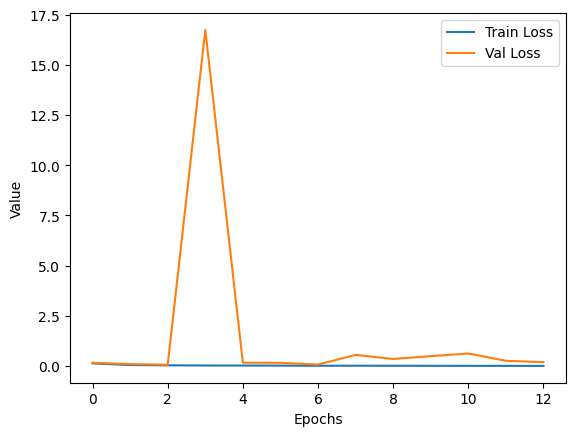

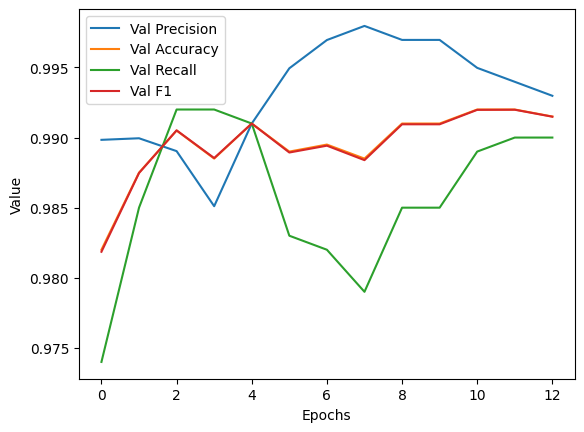

In [ ]:
train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           495     |          5
Spoof           17     |        483


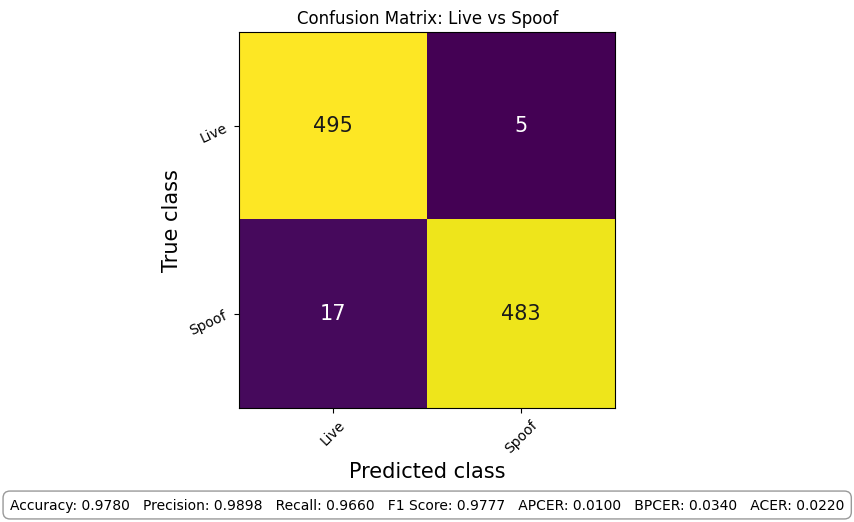

Accuracy: 0.9780
Precision: 0.9898
Recall:    0.9660
F1 Score:  0.9777
Spoofing Metrics: APCER: 0.0100, BPCER: 0.0340, ACER: 0.0220


In [ ]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.5)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live         19660     |        263
Spoof         1442     |      45805


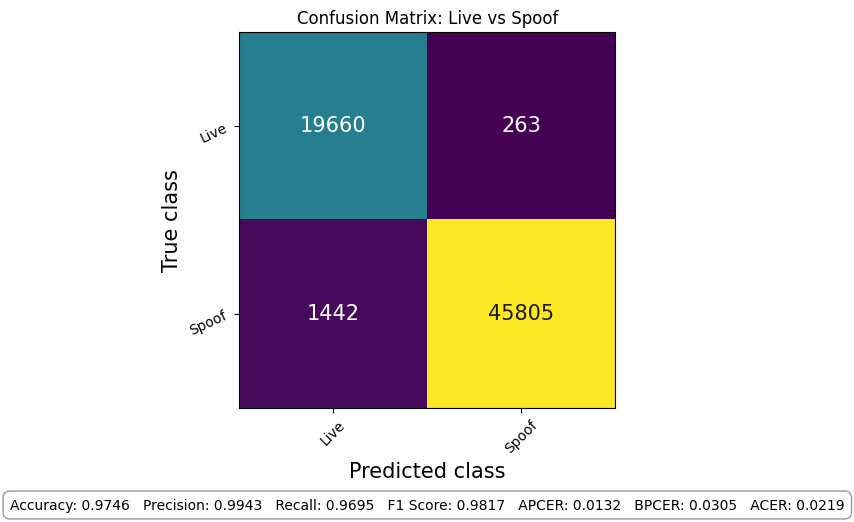

Accuracy: 0.9746
Precision: 0.9943
Recall:    0.9695
F1 Score:  0.9817
Spoofing Metrics: APCER: 0.0132, BPCER: 0.0305, ACER: 0.0219


In [ ]:
test_loader = DataLoader(test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True
                                )
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.5)

In [ ]:
def analyze_spoof_types(
    model: torch.nn.Module,
    dataset: Subset,
    device: torch.device,
    val_transforms: v2.Compose,
):
    """
    Analyzes model performance across different spoof types.
    Spoof type is at index 40 in the label array.
    """
    spoof_type_labels = {
        0: "Live",
        1: "Photo",
        2: "Poster",
        3: "A4",
        4: "Face Mask",
        5: "Upper Body Mask",
        6: "Region Mask",
        8: "Pad",
        7: "PC",
        9: "Phone",
        10: "3D Mask",
    }

    model.eval()

    # Dictionary to store results per spoof type
    spoof_type_results = {}

    with torch.no_grad():

        for idx in range(len(dataset)):
            img, label = dataset[idx]

            if hasattr(dataset, "dataset"):  # If it's a Subset
                actual_idx = dataset.indices[idx]
                image_key = dataset.dataset.image_keys[actual_idx]
                full_labels = dataset.dataset.label_dict[image_key]
            else:
                image_key = dataset.image_keys[idx]
                full_labels = dataset.label_dict[image_key]

            # Get the original key to access full label info

            spoof_type = full_labels[40]  # Spoof type at index 40
            live_spoof_label = full_labels[43]  # Live/Spoof at index 43

            # Only analyze spoof images (label = 1)
            if live_spoof_label != 1:
                continue

            # Prepare image for model
            img = img.unsqueeze(0).to(device)
            img = val_transforms(img)

            # Get prediction
            output = model(img)
            pred = torch.argmax(output, dim=1).item()
            # probs = torch.nn.functional.sigmoid(output)
            #pred = (probs[:, 1] > 0.0143).long().item
            # Initialize spoof type entry if needed
            if spoof_type not in spoof_type_results:
                spoof_type_results[spoof_type] = {
                    "total": 0,
                    "correct": 0,
                    "incorrect": 0,
                }

            # Update statistics
            spoof_type_results[spoof_type]["total"] += 1
            if pred == 1:  # Correctly identified as spoof
                spoof_type_results[spoof_type]["correct"] += 1
            else:  # Incorrectly identified as live
                spoof_type_results[spoof_type]["incorrect"] += 1

    # Calculate accuracy per spoof type
    results_df = []
    for spoof_type, stats in sorted(spoof_type_results.items()):
        accuracy = (
            (stats["correct"] / stats["total"] * 100) if stats["total"] > 0 else 0
        )
        results_df.append(
            {
                "Spoof Type": spoof_type_labels.get(spoof_type, "Unknown"),
                "Type ID": spoof_type,
                "Total": stats["total"],
                "Correct": stats["correct"],
                "Incorrect": stats["incorrect"],
                "Accuracy (%)": accuracy,
            }
        )

    results_df = pd.DataFrame(results_df)
    results_df = results_df.sort_values("Accuracy (%)")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart of accuracy per spoof type
    ax1.barh(
        results_df["Spoof Type"].astype(str),
        results_df["Accuracy (%)"],
        color=[
            "red" if x < 50 else "orange" if x < 80 else "green"
            for x in results_df["Accuracy (%)"]
        ],
    )
    ax1.set_xlabel("Accuracy (%)")
    ax1.set_ylabel("Spoof Type")
    ax1.set_title("Model Accuracy by Spoof Type")
    ax1.axvline(x=50, color="red", linestyle="--", alpha=0.5, label="50% threshold")
    ax1.legend()
    ax1.grid(axis="x", alpha=0.3)

    # Stacked bar chart showing correct vs incorrect
    ax2.barh(
        results_df["Spoof Type"].astype(str),
        results_df["Correct"],
        label="Correct (Detected as Spoof)",
        color="green",
        alpha=0.7,
    )
    ax2.barh(
        results_df["Spoof Type"].astype(str),
        results_df["Incorrect"],
        left=results_df["Correct"],
        label="Incorrect (Detected as Live)",
        color="red",
        alpha=0.7,
    )
    ax2.set_xlabel("Number of Samples")
    ax2.set_ylabel("Spoof Type")
    ax2.set_title("Correct vs Incorrect Predictions by Spoof Type")
    ax2.legend()
    ax2.grid(axis="x", alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nSpoof Type Analysis Results:")
    print("=" * 80)
    print(results_df.to_string(index=False))
    print("\n" + "=" * 80)
    print(f"\nWorst Performing Spoof Types (Accuracy < 70%):")
    worst = results_df[results_df["Accuracy (%)"] < 70]
    if len(worst) > 0:
        print(worst.to_string(index=False))
    else:
        print("None - All spoof types have >70% accuracy!")

    return results_df, fig


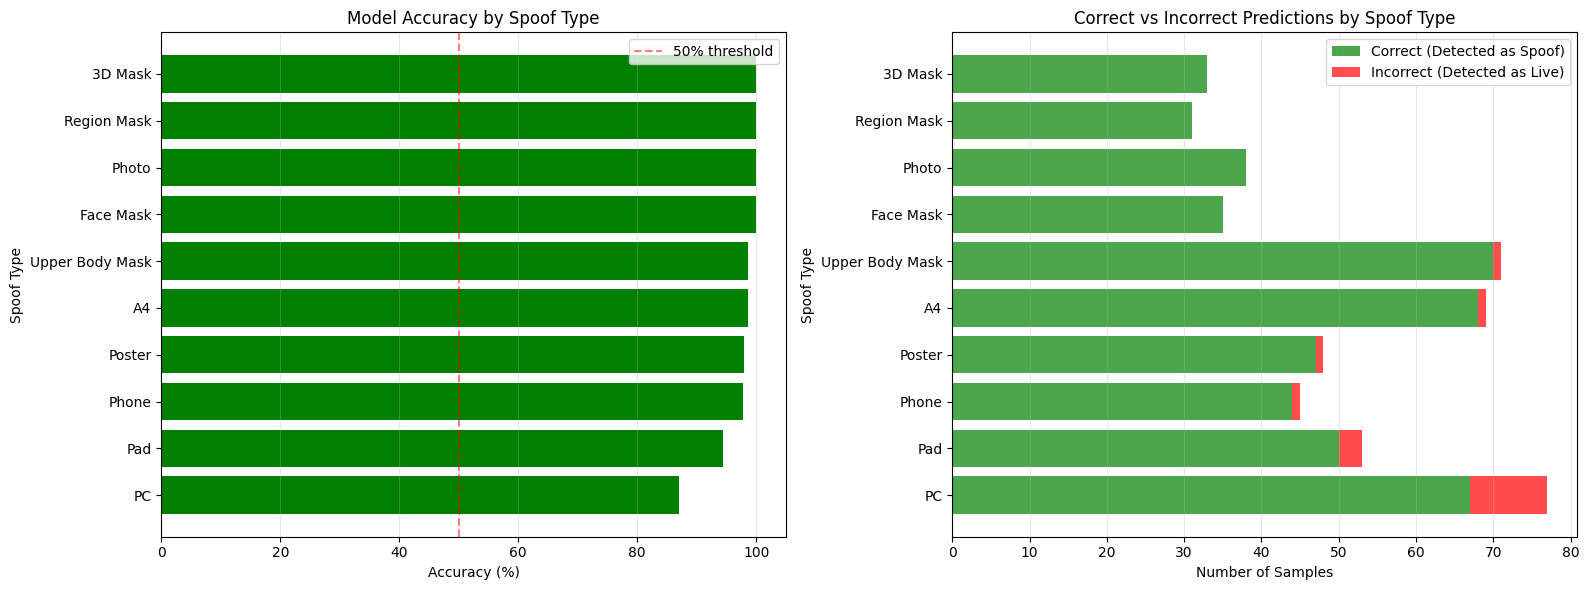


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     77       67         10     87.012987
            Pad        8     53       50          3     94.339623
          Phone        9     45       44          1     97.777778
         Poster        2     48       47          1     97.916667
             A4        3     69       68          1     98.550725
Upper Body Mask        5     71       70          1     98.591549
      Face Mask        4     35       35          0    100.000000
          Photo        1     38       38          0    100.000000
    Region Mask        6     31       31          0    100.000000
        3D Mask       10     33       33          0    100.000000


Worst Performing Spoof Types (Accuracy < 70%):
None - All spoof types have >70% accuracy!


In [ ]:
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [ ]:
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_roc_auc(model, dataloader, device, val_transforms=None, title="ROC Curve"):
    """
    Plot ROC curve and calculate AUC for binary classification.
    
    Returns:
    - fpr: False Positive Rates
    - tpr: True Positive Rates
    - roc_auc: AUC score
    - fig: Matplotlib figure
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            if val_transforms is not None:
                images = val_transforms(images)
            
            outputs = model(images)
            
            # Get probabilities for spoof class (class 1)
            # Assuming model outputs logits for 2 classes
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of spoof
            # Or use sigmoid if single output: probs = torch.sigmoid(outputs).squeeze()
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate all batches
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Check if we have both classes
    if len(np.unique(all_labels)) < 2:
        print("Warning: Only one class present in the data.")
        return None, None, None, None
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax1.set_ylabel('True Positive Rate (TPR / Recall)', fontsize=12)
    ax1.set_title(f'ROC Curve: {title}', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Add important thresholds
    for threshold in [0.3, 0.5, 0.7]:
        idx = np.argmin(np.abs(thresholds - threshold))
        ax1.plot(fpr[idx], tpr[idx], 'ro', markersize=8)
        ax1.annotate(f'Thr={threshold:.1f}\nFPR={fpr[idx]:.3f}\nTPR={tpr[idx]:.3f}',
                    xy=(fpr[idx], tpr[idx]),
                    xytext=(fpr[idx]+0.1, tpr[idx]-0.1),
                    fontsize=9,
                    arrowprops=dict(arrowstyle="->", color='red', alpha=0.7))
    
    # 2. Threshold Analysis (Spacing threshold)
    ax2.plot(thresholds, tpr, 'b-', lw=2, label='True Positive Rate')
    ax2.plot(thresholds, 1-fpr, 'g-', lw=2, label='True Negative Rate')
    ax2.plot(thresholds, tpr - fpr, 'r-', lw=2, label='TPR - FPR (Youden Index)')
    
    # Find optimal threshold (Youden's J statistic)
    youden_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[youden_idx]
    optimal_tpr = tpr[youden_idx]
    optimal_fpr = fpr[youden_idx]
    
    ax2.axvline(x=optimal_threshold, color='k', linestyle='--', alpha=0.7,
                label=f'Optimal Thr: {optimal_threshold:.3f}')
    
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Rate', fontsize=12)
    ax2.set_title(f'Threshold Analysis\nOptimal: {optimal_threshold:.3f}', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    
    # Print statistics
    print("\n" + "="*60)
    print("ROC-AUC ANALYSIS")
    print("="*60)
    print(f"AUC Score: {roc_auc:.6f}")
    print(f"Optimal Threshold (Youden): {optimal_threshold:.4f}")
    print(f"At optimal threshold:")
    print(f"  - True Positive Rate (Recall): {optimal_tpr:.4f}")
    print(f"  - False Positive Rate: {optimal_fpr:.4f}")
    print(f"  - False Negative Rate: {1-optimal_tpr:.4f}")
    print(f"  - True Negative Rate: {1-optimal_fpr:.4f}")
    
    return fig, fpr, tpr, roc_auc, optimal_threshold


def plot_precision_recall_curve(model, dataloader, device, val_transforms=None):
    """
    Plot Precision-Recall curve for imbalanced datasets.
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            if val_transforms is not None:
                images = val_transforms(images)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Spoof probability
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot PR curve
    ax.plot(recall, precision, color='blue', lw=2, 
            label=f'PR curve (AP = {avg_precision:.4f})')
    
    # Baseline (random classifier)
    spoof_ratio = np.mean(all_labels)
    ax.axhline(y=spoof_ratio, color='red', linestyle='--', 
               label=f'Random (spoof ratio: {spoof_ratio:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(loc="lower left")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    print(f"\nAverage Precision (AP): {avg_precision:.6f}")
    print(f"Spoof ratio in dataset: {spoof_ratio:.4f}")
    
    return fig, precision, recall, avg_precision


def comprehensive_evaluation(model, train_loader, val_loader, device, 
                           train_transforms=None, val_transforms=None):
    """
    Comprehensive evaluation with ROC, PR curves, and confusion matrices.
    """
    print("="*70)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*70)
    
    # 1. Evaluate on validation set
    print("\n1. Validation Set Evaluation:")
    fig_val, fpr_val, tpr_val, auc_val, opt_thr_val = plot_roc_auc(
        model, val_loader, device, val_transforms, "Validation Set"
    )
    
    # 2. Evaluate on training set (check overfitting)
    print("\n2. Training Set Evaluation (Check Overfitting):")
    fig_train, fpr_train, tpr_train, auc_train, _ = plot_roc_auc(
        model, train_loader, device, train_transforms, "Training Set"
    )
    
    # 3. Precision-Recall curve
    print("\n3. Precision-Recall Analysis:")
    fig_pr, precision, recall, avg_precision = plot_precision_recall_curve(
        model, val_loader, device, val_transforms
    )
    
    # 4. Calculate metrics at optimal threshold
    print("\n4. Performance at Optimal Threshold:")
    if opt_thr_val is not None:
        # Re-evaluate with optimal threshold
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                if val_transforms is not None:
                    images = val_transforms(images)
                
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = (probs > opt_thr_val).long()
                
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        from sklearn.metrics import classification_report, confusion_matrix
        
        print(f"\nClassification Report (Threshold = {opt_thr_val:.3f}):")
        print(classification_report(all_labels, all_preds, 
                                    target_names=['Live', 'Spoof']))
        
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Confusion Matrix:")
        print(f"               Predicted Live  |  Predicted Spoof")
        print(f"Actual Live:    {cm[0,0]:6d}            {cm[0,1]:6d}")
        print(f"Actual Spoof:   {cm[1,0]:6d}            {cm[1,1]:6d}")
    
    # 5. Compare training vs validation AUC (overfitting check)
    print("\n5. Overfitting Analysis:")
    print(f"Training AUC:   {auc_train:.6f}")
    print(f"Validation AUC: {auc_val:.6f}")
    print(f"Difference:     {abs(auc_train - auc_val):.6f}")
    
    if auc_train - auc_val > 0.05:
        print("⚠️  Warning: Possible overfitting (train AUC > val AUC by > 0.05)")
    
    # Create comparison figure
    fig_compare, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr_train, tpr_train, 'b-', lw=2, alpha=0.7, 
            label=f'Train AUC = {auc_train:.4f}')
    ax.plot(fpr_val, tpr_val, 'r-', lw=2, alpha=0.7, 
            label=f'Val AUC = {auc_val:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('Training vs Validation ROC Curves', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return {
        'val_auc': auc_val,
        'train_auc': auc_train,
        'optimal_threshold': opt_thr_val,
        'avg_precision': avg_precision,
        'figures': {
            'roc_val': fig_val,
            'roc_train': fig_train,
            'pr_curve': fig_pr,
            'comparison': fig_compare
        }
    }

In [ ]:


save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig, spoof_fig=spoof_fig, params=params)

Saving results to: train_results\train_23


In [ ]:


# Run the analysis


In [ ]:
# # Check a few samples
# for i in range(5):
#     _, label = small_test_ds[i]
#     print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

In [ ]:
# # Test with a known Live sample
# img, label = small_test_ds[2]  # Adjust index to find a Live sample
# print(f"True label: {'Live' if label == 0 else 'Spoof'}")

# img = img.unsqueeze(0).to(device)
# img = gpu_transforms_val(img)
# output = model(img)
# pred = torch.argmax(output, dim=1).item()
# print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

In [ ]:


# # Analyze training dataset distribution
# train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_train_ds)

In [ ]:
# from torchmetrics.classification import (
#     MulticlassConfusionMatrix,
#     Accuracy,
#     Precision,
#     Recall,
#     F1Score,
#     AUROC
# )
# from spoofdet.spoofing_metric import SpoofingMetric


# def evaluate_model(
#     model,
#     dataloader: DataLoader,
#     device: torch.device,
#     val_transforms: v2.Compose | None = None,
#     threshold: float = 0.5,
# ):
#     confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
#     accuracy = Accuracy(task="binary").to(device)
#     precision = Precision(task="binary").to(device)
#     recall = Recall(task="binary").to(device)
#     f1 = F1Score(task="binary").to(device)
#     spoof_metric = SpoofingMetric().to(device)
#     auroc_metric = AUROC(task='binary').to(device)
#     model.eval()
#     with torch.no_grad():
#         for batch_idx, (images, labels) in enumerate(dataloader):
#             images, labels = images.to(device), labels.to(device)
#             images = val_transforms(images)
#             outputs = model(images)
            
#             # FIX: Use Softmax for 2-class logits, not Sigmoid
#             probs = torch.nn.functional.softmax(outputs, dim=1)
            
#             # Class 1 is 'Spoof'. We compare prob(Spoof) > threshold
#             preds = (probs[:, 1] > threshold).long()

#             # Update the metrics with this batch
#             confmat.update(preds, labels)
#             accuracy.update(preds, labels)
#             precision.update(preds, labels)
#             recall.update(preds, labels)
#             f1.update(preds, labels)
#             spoof_metric.update(preds, labels)
#             auroc_metric.update(probs[:, 1], labels)

#     # Compute the final results
#     final_matrix = confmat.compute()
#     print("\nConfusion Matrix:")
#     print(f"         Predicted Live | Predicted Spoof")
#     print(f"Live        {final_matrix[0,0]:>6}     |     {final_matrix[0,1]:>6}")
#     print(f"Spoof       {final_matrix[1,0]:>6}     |     {final_matrix[1,1]:>6}")
#     acc_val = accuracy.compute()
#     prec_val = precision.compute()
#     rec_val = recall.compute()
#     f1_val = f1.compute()
#     spoof_metric_val = spoof_metric.compute()
#     auroc_val = auroc_metric.compute()

#     # Plot the matrix
#     fig, ax = confmat.plot(labels=["Live", "Spoof"])
#     ax.set_title("Confusion Matrix: Live vs Spoof")

#     # Add metrics as text below the matrix
#     metrics_text = (
#         f"Accuracy: {acc_val:.4f}   "
#         f"Precision: {prec_val:.4f}   "
#         f"Recall: {rec_val:.4f}   "
#         f"F1 Score: {f1_val:.4f}   "
#         f"APCER: {spoof_metric_val['APCER']:.4f}   "
#         f"BPCER: {spoof_metric_val['BPCER']:.4f}   "
#         f"ACER: {spoof_metric_val['ACER']:.4f}"
#     )

#     # Position the text at the bottom center of the figure
#     fig.text(
#         0.5,
#         -0.05,
#         metrics_text,
#         ha="center",
#         fontsize=10,
#         bbox=dict(
#             facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.5"
#         ),
#     )

#     plt.show()

#     print(f"Accuracy: {acc_val:.4f}")
#     print(f"Precision: {prec_val:.4f}")
#     print(f"Recall:    {rec_val:.4f}")
#     print(f"F1 Score:  {f1_val:.4f}")
#     print(
#         f"Spoofing Metrics: APCER: {spoof_metric_val['APCER']:.4f}, BPCER: {spoof_metric_val['BPCER']:.4f}, ACER: {spoof_metric_val['ACER']:.4f}"
#     )
#     print(f"AUROC: {auroc_val:.4f}")

#     return fig, acc_val, prec_val, rec_val, f1_val, spoof_metric_val
# evaluate_model(
#     model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.01)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_roc_auc(model, dataloader, device, val_transforms=None, title="ROC Curve"):
    """
    Plot ROC curve and calculate AUC for binary classification.
    
    Returns:
    - fpr: False Positive Rates
    - tpr: True Positive Rates
    - roc_auc: AUC score
    - fig: Matplotlib figure
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            if val_transforms is not None:
                images = val_transforms(images)
            
            outputs = model(images)
            
            # Get probabilities for spoof class (class 1)
            # Assuming model outputs logits for 2 classes
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of spoof
            # Or use sigmoid if single output: probs = torch.sigmoid(outputs).squeeze()
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate all batches
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Check if we have both classes
    if len(np.unique(all_labels)) < 2:
        print("Warning: Only one class present in the data.")
        return None, None, None, None
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12)
    ax1.set_ylabel('True Positive Rate (TPR / Recall)', fontsize=12)
    ax1.set_title(f'ROC Curve: {title}', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Add important thresholds
    for threshold in [0.3, 0.5, 0.7]:
        idx = np.argmin(np.abs(thresholds - threshold))
        ax1.plot(fpr[idx], tpr[idx], 'ro', markersize=8)
        ax1.annotate(f'Thr={threshold:.1f}\nFPR={fpr[idx]:.3f}\nTPR={tpr[idx]:.3f}',
                    xy=(fpr[idx], tpr[idx]),
                    xytext=(fpr[idx]+0.1, tpr[idx]-0.1),
                    fontsize=9,
                    arrowprops=dict(arrowstyle="->", color='red', alpha=0.7))
    
    # 2. Threshold Analysis (Spacing threshold)
    ax2.plot(thresholds, tpr, 'b-', lw=2, label='True Positive Rate')
    ax2.plot(thresholds, 1-fpr, 'g-', lw=2, label='True Negative Rate')
    ax2.plot(thresholds, tpr - fpr, 'r-', lw=2, label='TPR - FPR (Youden Index)')
    
    # Find optimal threshold (Youden's J statistic)
    youden_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[youden_idx]
    optimal_tpr = tpr[youden_idx]
    optimal_fpr = fpr[youden_idx]
    
    ax2.axvline(x=optimal_threshold, color='k', linestyle='--', alpha=0.7,
                label=f'Optimal Thr: {optimal_threshold:.3f}')
    
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Rate', fontsize=12)
    ax2.set_title(f'Threshold Analysis\nOptimal: {optimal_threshold:.3f}', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    plt.tight_layout()
    
    # Print statistics
    print("\n" + "="*60)
    print("ROC-AUC ANALYSIS")
    print("="*60)
    print(f"AUC Score: {roc_auc:.6f}")
    print(f"Optimal Threshold (Youden): {optimal_threshold:.4f}")
    print(f"At optimal threshold:")
    print(f"  - True Positive Rate (Recall): {optimal_tpr:.4f}")
    print(f"  - False Positive Rate: {optimal_fpr:.4f}")
    print(f"  - False Negative Rate: {1-optimal_tpr:.4f}")
    print(f"  - True Negative Rate: {1-optimal_fpr:.4f}")
    
    return fig, fpr, tpr, roc_auc, optimal_threshold


def plot_precision_recall_curve(model, dataloader, device, val_transforms=None):
    """
    Plot Precision-Recall curve for imbalanced datasets.
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            if val_transforms is not None:
                images = val_transforms(images)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Spoof probability
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot PR curve
    ax.plot(recall, precision, color='blue', lw=2, 
            label=f'PR curve (AP = {avg_precision:.4f})')
    
    # Baseline (random classifier)
    spoof_ratio = np.mean(all_labels)
    ax.axhline(y=spoof_ratio, color='red', linestyle='--', 
               label=f'Random (spoof ratio: {spoof_ratio:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(loc="lower left")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    print(f"\nAverage Precision (AP): {avg_precision:.6f}")
    print(f"Spoof ratio in dataset: {spoof_ratio:.4f}")
    
    return fig, precision, recall, avg_precision


def comprehensive_evaluation(model, train_loader, val_loader, device, 
                           train_transforms=None, val_transforms=None):
    """
    Comprehensive evaluation with ROC, PR curves, and confusion matrices.
    """
    print("="*70)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*70)
    
    # 1. Evaluate on validation set
    print("\n1. Validation Set Evaluation:")
    fig_val, fpr_val, tpr_val, auc_val, opt_thr_val = plot_roc_auc(
        model, val_loader, device, val_transforms, "Validation Set"
    )
    
    # 2. Evaluate on training set (check overfitting)
    print("\n2. Training Set Evaluation (Check Overfitting):")
    fig_train, fpr_train, tpr_train, auc_train, _ = plot_roc_auc(
        model, train_loader, device, train_transforms, "Training Set"
    )
    
    # 3. Precision-Recall curve
    print("\n3. Precision-Recall Analysis:")
    fig_pr, precision, recall, avg_precision = plot_precision_recall_curve(
        model, val_loader, device, val_transforms
    )
    
    # 4. Calculate metrics at optimal threshold
    print("\n4. Performance at Optimal Threshold:")
    if opt_thr_val is not None:
        # Re-evaluate with optimal threshold
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                if val_transforms is not None:
                    images = val_transforms(images)
                
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = (probs > opt_thr_val).long()
                
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        from sklearn.metrics import classification_report, confusion_matrix
        
        print(f"\nClassification Report (Threshold = {opt_thr_val:.3f}):")
        print(classification_report(all_labels, all_preds, 
                                    target_names=['Live', 'Spoof']))
        
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Confusion Matrix:")
        print(f"               Predicted Live  |  Predicted Spoof")
        print(f"Actual Live:    {cm[0,0]:6d}            {cm[0,1]:6d}")
        print(f"Actual Spoof:   {cm[1,0]:6d}            {cm[1,1]:6d}")
    
    # 5. Compare training vs validation AUC (overfitting check)
    print("\n5. Overfitting Analysis:")
    print(f"Training AUC:   {auc_train:.6f}")
    print(f"Validation AUC: {auc_val:.6f}")
    print(f"Difference:     {abs(auc_train - auc_val):.6f}")
    
    if auc_train - auc_val > 0.05:
        print("⚠️  Warning: Possible overfitting (train AUC > val AUC by > 0.05)")
    
    # Create comparison figure
    fig_compare, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr_train, tpr_train, 'b-', lw=2, alpha=0.7, 
            label=f'Train AUC = {auc_train:.4f}')
    ax.plot(fpr_val, tpr_val, 'r-', lw=2, alpha=0.7, 
            label=f'Val AUC = {auc_val:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('Training vs Validation ROC Curves', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return {
        'val_auc': auc_val,
        'train_auc': auc_train,
        'optimal_threshold': opt_thr_val,
        'avg_precision': avg_precision,
        'figures': {
            'roc_val': fig_val,
            'roc_train': fig_train,
            'pr_curve': fig_pr,
            'comparison': fig_compare
        }
    }


ROC-AUC ANALYSIS
AUC Score: 0.997432
Optimal Threshold (Youden): 0.5817
At optimal threshold:
  - True Positive Rate (Recall): 0.9920
  - False Positive Rate: 0.0110
  - False Negative Rate: 0.0080
  - True Negative Rate: 0.9890
COMPREHENSIVE MODEL EVALUATION

1. Validation Set Evaluation:

ROC-AUC ANALYSIS
AUC Score: 0.997432
Optimal Threshold (Youden): 0.5817
At optimal threshold:
  - True Positive Rate (Recall): 0.9920
  - False Positive Rate: 0.0110
  - False Negative Rate: 0.0080
  - True Negative Rate: 0.9890

2. Training Set Evaluation (Check Overfitting):

ROC-AUC ANALYSIS
AUC Score: 0.999536
Optimal Threshold (Youden): 0.7473
At optimal threshold:
  - True Positive Rate (Recall): 0.9972
  - False Positive Rate: 0.0018
  - False Negative Rate: 0.0028
  - True Negative Rate: 0.9982

3. Precision-Recall Analysis:

Average Precision (AP): 0.994283
Spoof ratio in dataset: 0.5000

4. Performance at Optimal Threshold:

Classification Report (Threshold = 0.582):
              precisi

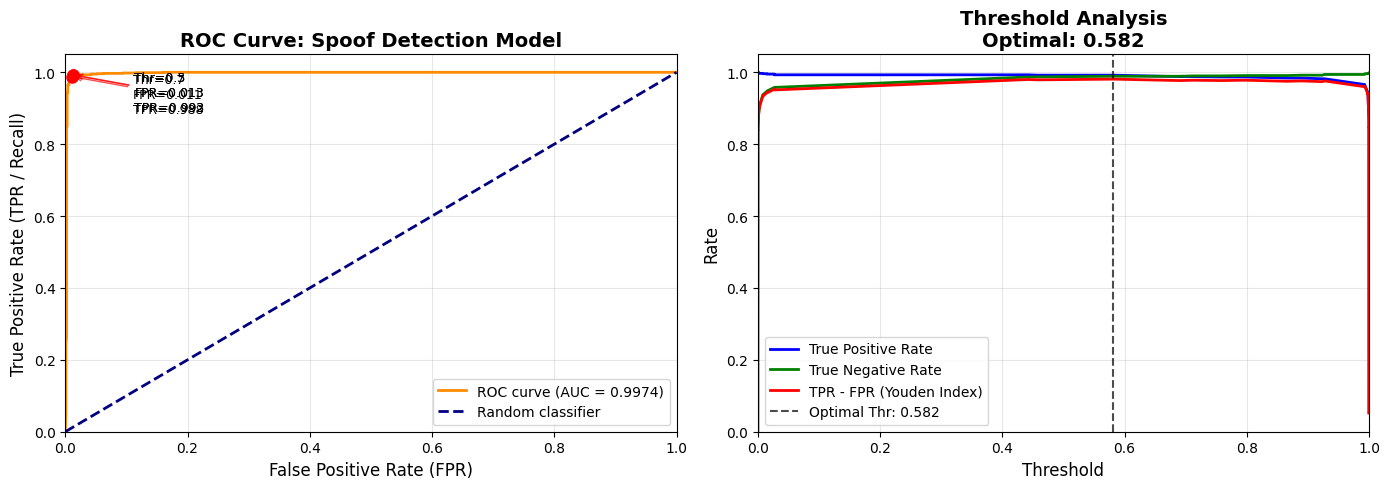

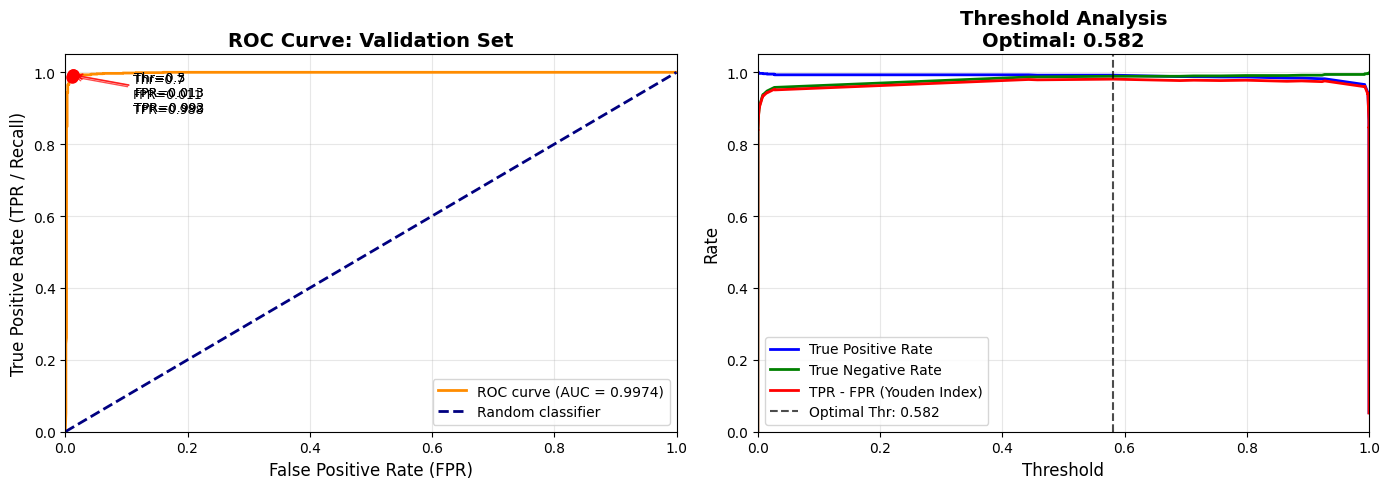

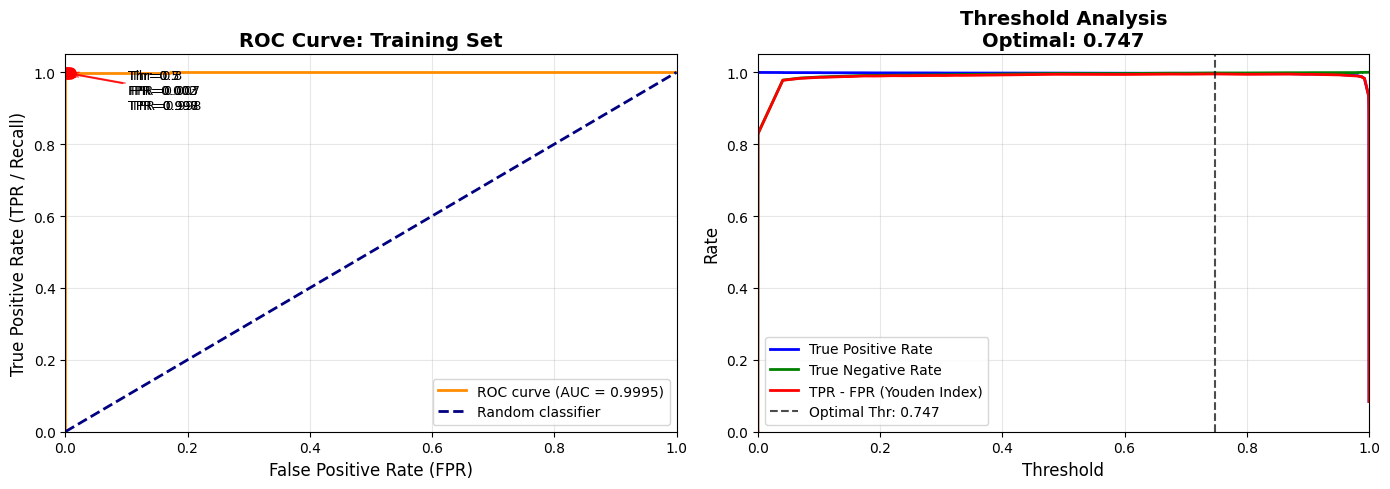

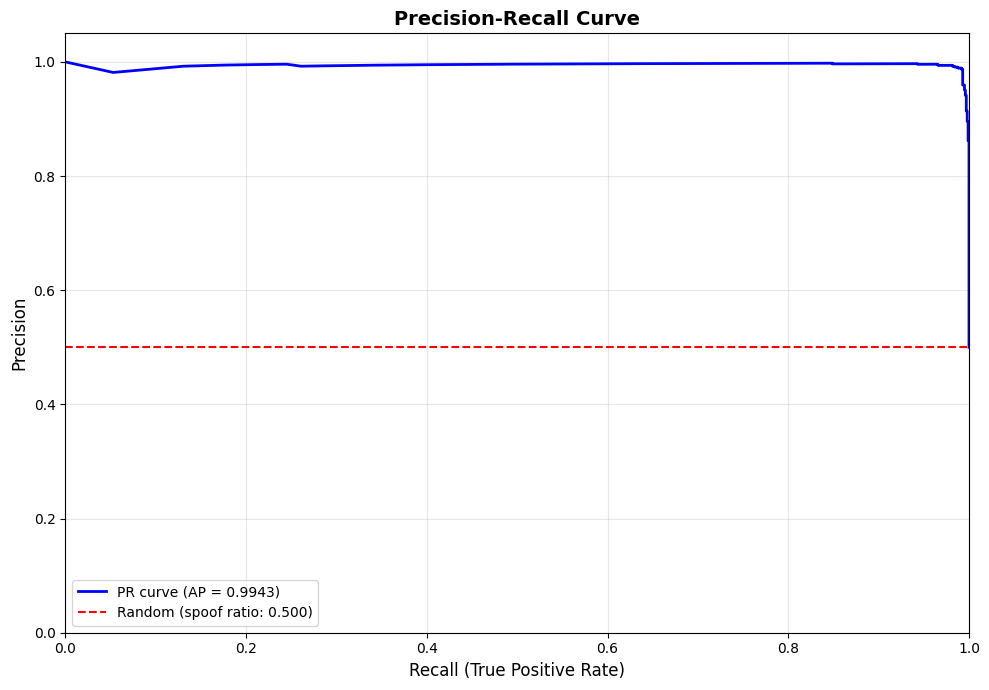

In [ ]:
# Simple ROC plot for your validation set
fig, fpr, tpr, auc_score, opt_threshold = plot_roc_auc(
    model=model,
    dataloader=small_val_loader,
    device=device,
    val_transforms=gpu_transforms_val,
    title="Spoof Detection Model"
)

# Or comprehensive evaluation
results = comprehensive_evaluation(
    model=model,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    device=device,
    train_transforms=gpu_transforms_train,
    val_transforms=gpu_transforms_val
)

# Save the best figure
results['figures']['roc_val'].savefig('roc_curve.png', dpi=300, bbox_inches='tight')